# Fits Datacube Access 

**DESCRIPTION:** 

This notebook shows how to extract the datacube output from the `.fits` files of SKIRT. 

Use the class `FitsDatacube` for loading and accessing the fits file, including contructing and displaying monochromatic images, band-convolved images, pixel spectra and integrated spectra. 
The accompanying `Filter` class loads and accesses `.filter` files, along with interpolating the discrete filter band data for use when convolving datacubes of arbituary wavelengths, as well as some basic plotting routines. 

See code below for example usages.

**REQUIRES:** 

numpy, matplotlib, scipy, astropy


In [1]:
# main file import
from fitsdatacube import FitsDatacube, Filter, GaussianPSF

# other useful imports
import numpy as np
import matplotlib.pyplot as plt

# jupyter notebook styling
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# matplotlib styling
import matplotlib
matplotlib.rcParams.update({'font.size': 24})
matplotlib.rcParams.update({'axes.linewidth': 2.0})

### File loading and basic access

In [23]:
FILENAME = 'fits_files/romulus_convert_5271_4_2_total.fits'
UNITS = ['Jy', 'angstrom']
fdc = FitsDatacube(FILENAME, ounits=UNITS)

In [24]:
fdc.shape     # form: (num of wavelengths, num of x pixels, num of y pixels)

(2889, 75, 75)

In [25]:
fdc[50, fdc.shape[-1]//2, fdc.shape[-1]//2]  # grab the flux value of the center pixel at the 50th wavelength

0.20887261629104614

In [26]:
fdc.wav[50]  # the value of the 50th wavelength (angstroms)

3442.7747649999997

In [27]:
fdc.wav_index(5000) # the wavelength index nearest to 5000 angstroms

1542

In [28]:
(1 - 3*fdc**2) # can do standard +,-,*,/,** operations on the object to affect the datacube

In [29]:
(fdc >= 0.1) & (0.2 < fdc < 0.3)  # can use comparison and logic operators <,>,<=,>=,==,!=,&,|,~ to give boolean valued datacubes (used for something like masks)

In [30]:
fdc.infer_R()  # infers the spectral resolution from the data

3999.2538031033096

fdc.units  # get the unit system (flux, wavelength)

### Pixel spectrum

Use `fdc.get_spectrum(x, y)` to get the raw data for the spectrum at pixel `(x, y)` and use `fdc.wav` to get the corresponding wavelengths. The default data output of SKIRT is in spectral flux density (Jy) and the wavelengths are in microns (though I convert above to angstroms). See `FitsDatacube._general_plot` for most of the plotting options.

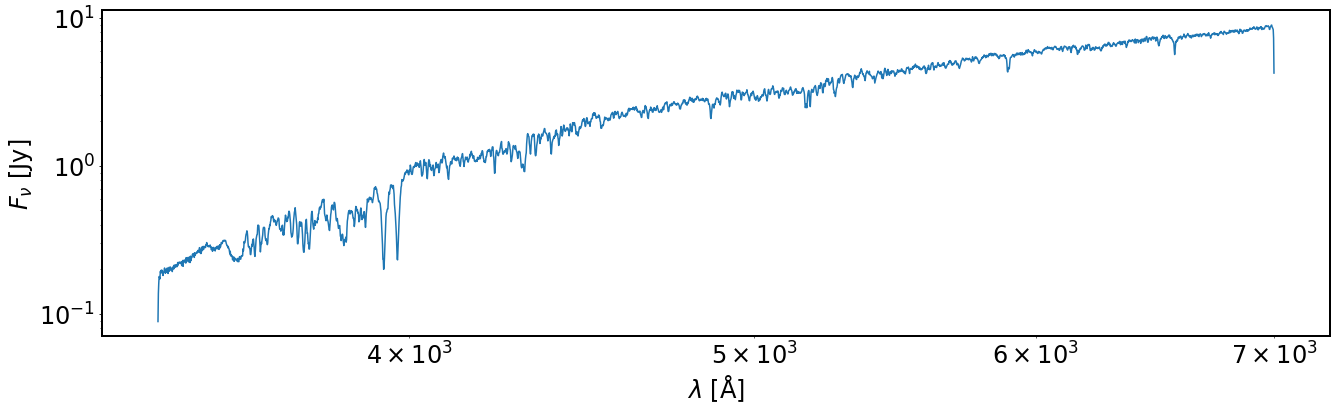

In [31]:
fig, ax = fdc.plot_spectrum(fdc.shape[-1]//2, fdc.shape[-1]//2, xscale='log', yscale='log', xlabel=r'$\lambda$ [Å]', ylabel=r'$F_\nu$ [Jy]', figsize=(22, 6))  # in pixels

### Integrated spectrum

Use `fdc.get_integrated_spectrum()` to get the raw data for the integrated spectrum.

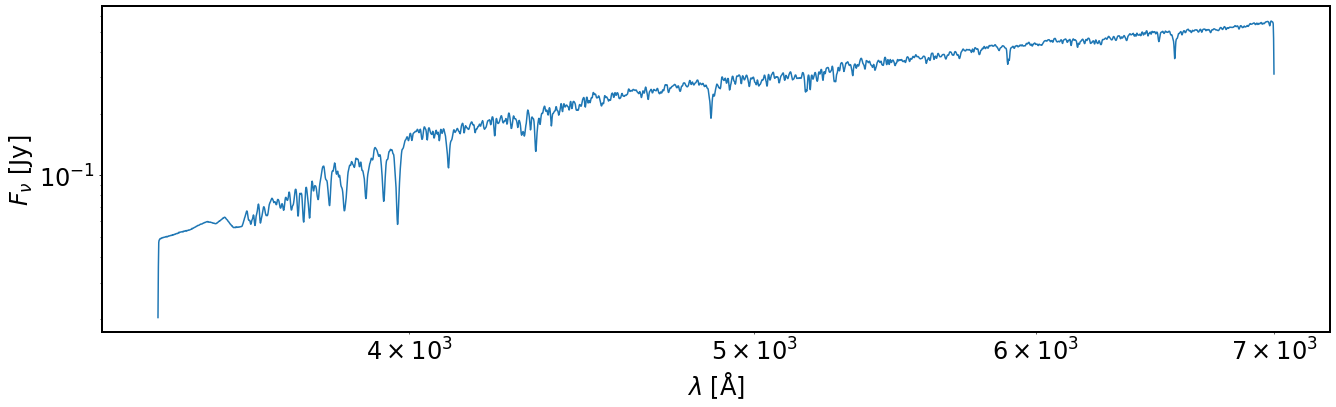

In [32]:
fig, ax = fdc.plot_integrated_spectrum(xscale='log', yscale='log', xlabel=r'$\lambda$ [Å]', ylabel=r'$F_\nu$ [Jy]', figsize=(22, 6))

### Monochromatic image

Use `fdc.get_image(wav)` to get the raw data for the image with wavelength nearest to `wav` (microns by default, I converted to angstroms for this example when loading above).

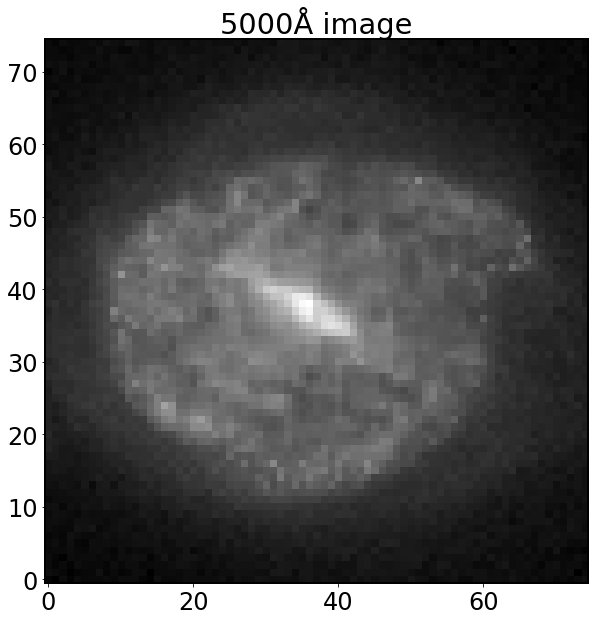

In [33]:
fig, ax = (fdc**0.4).plot_image(5000, figsize=(10, 10), title='5000Å image')

### Band-convolved image

Use `fdc.get_convolved_image(filt)` to get the raw data for the image convolved with filter function `filt`. To obtain the interpolated `filt` function from an ascii file (space-delimited csv) containing a list wavelengths and throughputs, use `Filter(filename)`. When called, a Filter instance acts like a function but also has some convenient functions such as plotting routines.

#### Load filters

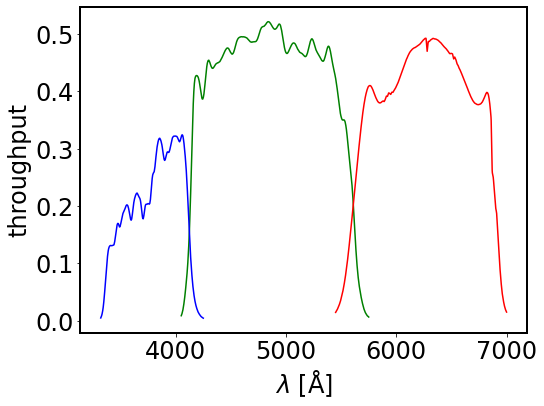

In [34]:
gfilt = Filter('filters/gband.filter', ounits=[UNITS[1], '1'])
gsubplot = gfilt.plot_interpolated(4050, 5750, 1000, color='green', xlabel=r'$\lambda$ [Å]', ylabel='throughput')

rfilt = Filter('filters/rband.filter', ounits=[UNITS[1], '1'])
rsubplot = rfilt.plot_interpolated(5450, 7000, 1000, subplot=gsubplot, color='red')

ufilt = Filter('filters/uband.filter', ounits=[UNITS[1], '1'])
usubplot = ufilt.plot_interpolated(3320, 4250, 1000, subplot=gsubplot, color='blue')

#### Get image and plot

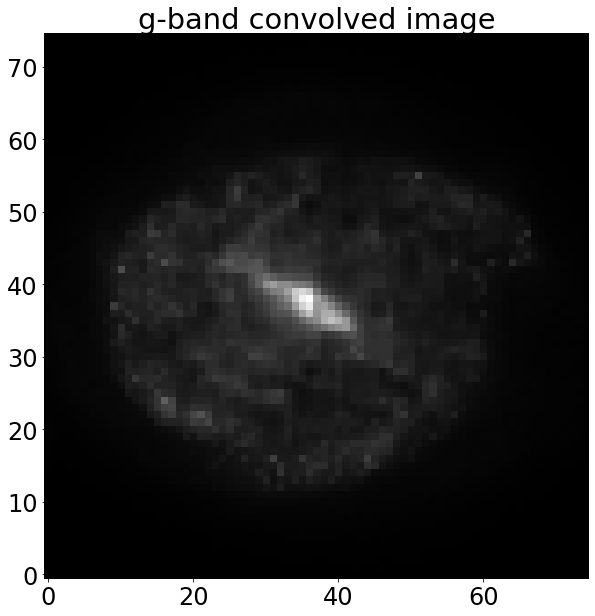

In [35]:
fig, ax = fdc.plot_convolved_image(gfilt, figsize=(10, 10), title='g-band convolved image')

### PSF Convolution

It is common to want to convolve a datacube with a PSF of a certain FWHM or sigma to create synthetic images. We describe how to do this below.  

In [36]:
psf1 = GaussianPSF(fwhm=1, size=3)   # specify gaussian psf with 1 pixel fwhm and size 5x5
psf2 = GaussianPSF(sigma=0.8)        # specify gaussian psf with 0.8 pixel sigma and arbituary size (defined by full image)

In [37]:
psf1.kernel  # get psf kernel as a numpy array (note that psf2.kernel cannot yet be determined, since it requires an image to obtain a size)

array([[0.00308642, 0.04938272, 0.00308642],
       [0.04938272, 0.79012346, 0.04938272],
       [0.00308642, 0.04938272, 0.00308642]])

In [38]:
convolved_fdc1 = fdc.convolve_PSF(psf1)  # convolve the PSF over each monochromatic image in the datacube
convolved_fdc2 = fdc.convolve_PSF(psf2)

(<Figure size 576x432 with 1 Axes>, <AxesSubplot:>)

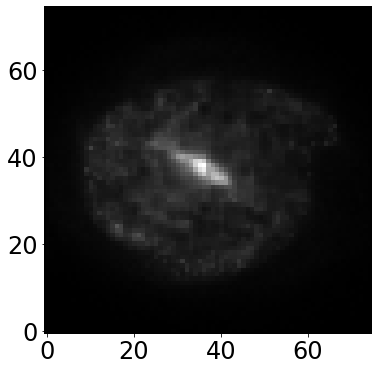

In [39]:
convolved_fdc1.plot_image(5000)

(<Figure size 576x432 with 1 Axes>, <AxesSubplot:>)

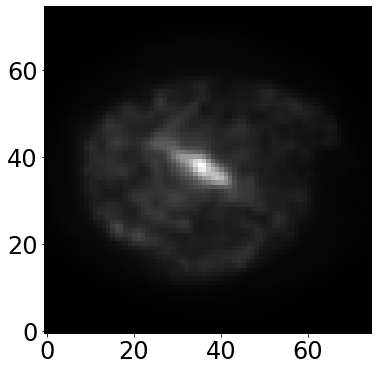

In [40]:
convolved_fdc2.plot_image(5000)

### Quantifying error

Here, we use higher-order moments of the photons to quantify the error for a given spaxel. These datacubes are optionally output in fits format by SKIRT by setting recordStatistics="true" for the instrument used. For more details, see https://skirt.ugent.be/root/_user_statistics.html.

In [41]:
FILENAME_STATS1 = 'fits_files/romulus_convert_5271_4_2_stats1.fits'
FILENAME_STATS2 = 'fits_files/romulus_convert_5271_4_2_stats2.fits'
FILENAME_STATS3 = 'fits_files/romulus_convert_5271_4_2_stats3.fits'
FILENAME_STATS4 = 'fits_files/romulus_convert_5271_4_2_stats4.fits'
NPHOTONS = 5e9  # total number of photon packets used in the SKIRT run

fdc_stats1 = FitsDatacube(FILENAME_STATS1, ounits=UNITS)
fdc_stats2 = FitsDatacube(FILENAME_STATS2, ounits=UNITS)
fdc_stats3 = FitsDatacube(FILENAME_STATS3, ounits=UNITS)
fdc_stats4 = FitsDatacube(FILENAME_STATS4, ounits=UNITS)
assert fdc_stats1.shape == fdc_stats2.shape == fdc_stats3.shape == fdc_stats4.shape

##### Relative Error (R)

This is can be interpreted as a fractional error on the result (i.e. percent error / 100). A value of R < 0.1 is reliable, and a value of R > 0.2 is unreliable.

In [42]:
R = (fdc_stats2/fdc_stats1**2 - 1/NPHOTONS)**0.5

##### Variance of the Variance (VOV)

This measures the statistical uncertainty in the value for R. The VOV should be below 0.1 to ensure that R is reliable enough.

In [43]:
VOV = (fdc_stats4 - 4*fdc_stats1*fdc_stats3/NPHOTONS + 8*fdc_stats2*fdc_stats1**2/NPHOTONS**2 - 4*fdc_stats1**4/NPHOTONS**3 - fdc_stats2**2/NPHOTONS)/(fdc_stats2 - fdc_stats1**2/NPHOTONS)**2

##### Figure of Merit (FOM)

Provides a measure for the efficiency of the simulation (higher is better).

In [44]:
TIMESPENT_SEC = 1449000
FOM = 1/TIMESPENT_SEC*(R**2)
print(FOM.sum())

0.34517556046063885


#### Get error image

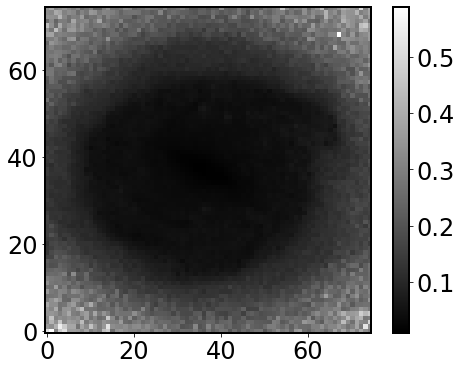

In [45]:
# relative error
fig, ax, im = R.plot_image(5000, ret_im=True)
fig.colorbar(im, ax=ax)

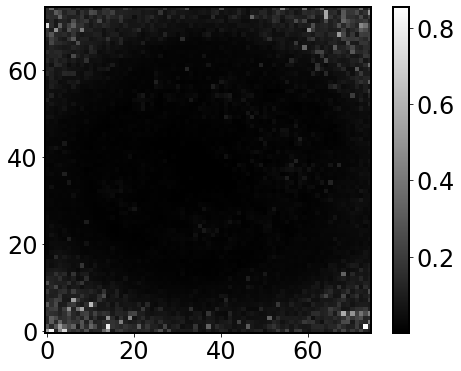

In [46]:
# uncertainty on the relative error
fig, ax, im = VOV.plot_image(5000, ret_im=True)
fig.colorbar(im, ax=ax)

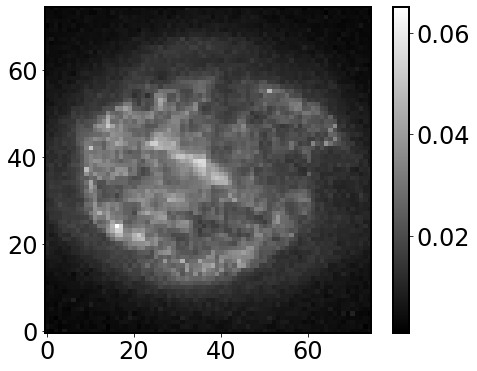

In [47]:
# absolute error
fig, ax, im = (fdc*R).plot_image(5000, ret_im=True)
fig.colorbar(im, ax=ax)

#### Get error spectrum

(<Figure size 1584x432 with 1 Axes>,
 <AxesSubplot:xlabel='$\\lambda$ [Å]', ylabel='$F_\\nu$ [Jy]'>)

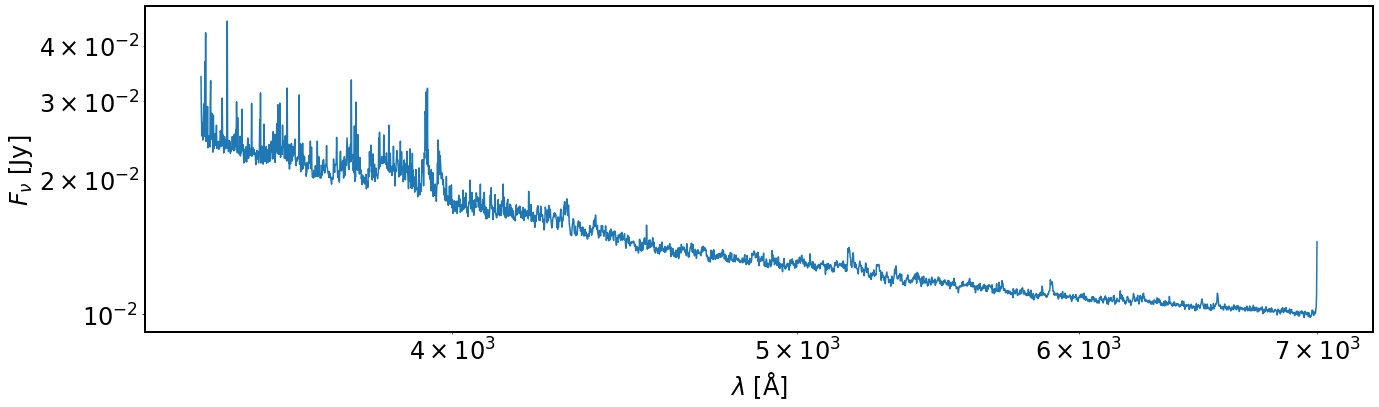

In [49]:
R.plot_spectrum(fdc.shape[-1]//2, fdc.shape[-1]//2, xscale='log', yscale='log', xlabel=r'$\lambda$ [Å]', ylabel=r'$F_\nu$ [Jy]', figsize=(22, 6))  # in pixels

### Exclude the bad spaxels

To exclude the bad spaxels, we can consider a mask defined by an error threshold as below. Multiplying this mask by the flux datacube effectively zeros out the bad spaxels.

In [50]:
strict_mask = (R < 0.1) & (VOV < 0.1)        # a more strict mask (use if possible)
lenient_mask = (R < 0.2) & (VOV < 0.2)       # a less strict mask (use if necessary)

(<Figure size 576x432 with 1 Axes>, <AxesSubplot:>)

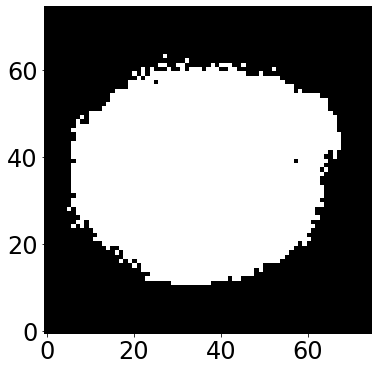

In [54]:
# visualize the strict mask at a given wavelength
strict_mask.plot_image(5000, vmin=0, vmax=1)

(<Figure size 576x432 with 1 Axes>, <AxesSubplot:>)

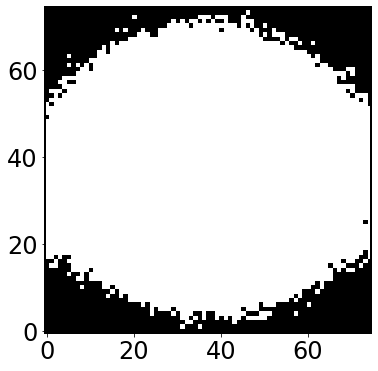

In [55]:
# visualize the mask at a given wavelength
lenient_mask.plot_image(5000, vmin=0, vmax=1)

(<Figure size 576x432 with 1 Axes>, <AxesSubplot:>)

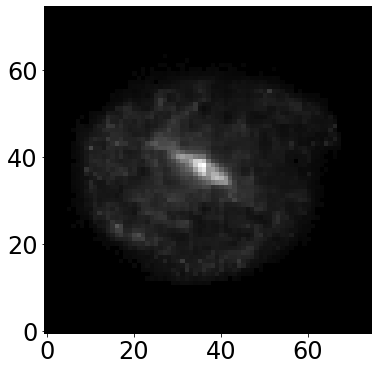

In [63]:
# Multiply the mask by the flux datacube to obtain an image with zeros at the bad spaxels.
(fdc*strict_mask).plot_image(5000, vmin=0)

# Dat SED Access

**DESCRIPTION:** 

The following code extracts data from a `.dat` file integrated spectrum output from SKIRT. Use the `load_dat_file` function to load the data into a Pandas DataFrame. A visualization of the result is shown below.

**REQUIRES:** 

numpy, matplotlib, pandas

In [32]:
# main import 
from fitsdatacube import load_dat_file

# other imports
import matplotlib.pyplot as plt

### Load dat file

In [33]:
dat = load_dat_file('PanEagle_eo_sed.dat')
dat

,wavelength; lambda (micron),total flux; F_nu (Jy),transparent flux; F_nu (Jy),direct primary flux; F_nu (Jy),scattered primary flux; F_nu (Jy),direct secondary flux; F_nu (Jy),scattered secondary flux; F_nu (Jy),transparent secondary flux; F_nu (Jy)
0,0.090000,0.000191,0.016423,0.000081,0.000110,0.000000,0.0,0.000000
1,0.091126,0.000365,0.032640,0.000187,0.000178,0.000000,0.0,0.000000
2,0.092267,0.000698,0.053010,0.000355,0.000344,0.000000,0.0,0.000000
3,0.093422,0.001219,0.091888,0.000722,0.000497,0.000000,0.0,0.000000
4,0.094591,0.002109,0.125285,0.001378,0.000731,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...
745,951.467194,1.217778,0.000000,0.000000,0.000000,1.217778,0.0,1.217817
746,963.374982,1.198623,0.000000,0.000000,0.000000,1.198623,0.0,1.198663
747,975.431799,1.159665,0.000000,0.000000,0.000000,1.159665,0.0,1.159701
748,987.639508,1.058846,0.000000,0.000000,0.000000,1.058846,0.0,1.058877


### Plot the integrated spectrum output

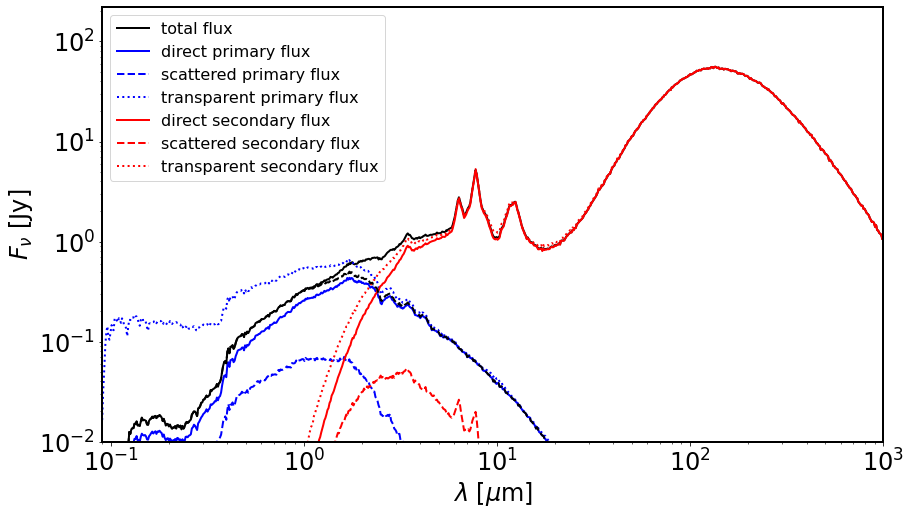

In [34]:
plt.figure(figsize=(14, 8))
plt.xscale('log')
plt.yscale('log')
plt.plot(dat['wavelength; lambda (micron)'], dat['total flux; F_nu (Jy)'], label='total flux', lw=2, color='black')
plt.plot(dat['wavelength; lambda (micron)'], dat['direct primary flux; F_nu (Jy)'], label='direct primary flux', lw=2, color='blue')
plt.plot(dat['wavelength; lambda (micron)'], dat['scattered primary flux; F_nu (Jy)'], label='scattered primary flux', lw=2, color='blue', ls='dashed')
plt.plot(dat['wavelength; lambda (micron)'], dat['transparent flux; F_nu (Jy)'], label='transparent primary flux', lw=2, color='blue', ls='dotted')
plt.plot(dat['wavelength; lambda (micron)'], dat['direct secondary flux; F_nu (Jy)'], label='direct secondary flux', lw=2, color='red')
plt.plot(dat['wavelength; lambda (micron)'], dat['scattered secondary flux; F_nu (Jy)'], label='scattered secondary flux', lw=2, color='red', ls='dashed')
plt.plot(dat['wavelength; lambda (micron)'], dat['transparent secondary flux; F_nu (Jy)'], label='transparent secondary flux', lw=2, color='red', ls='dotted')
plt.plot(dat['wavelength; lambda (micron)'], dat['direct primary flux; F_nu (Jy)'] + dat['scattered primary flux; F_nu (Jy)'], lw=2, ls='dashed', color='black')
plt.xlabel(r'$\lambda$ [$\mu$m]')
plt.ylabel(r'$F_\nu$ [Jy]')
plt.xlim([0.09, 1000])
plt.ylim([1e-2, None])
plt.legend(fontsize=16)

### Load and plot stats file

In [35]:
dat_stats = load_dat_file('PanEagle_eo_sedstats.dat')
dat_stats

,wavelength; lambda (micron),Sum[w_i**0] (1),Sum[w_i**1] (1),Sum[w_i**2] (1),Sum[w_i**3] (1),Sum[w_i**4] (1)
0,0.090000,3535.0,9.462883e+31,5.011441e+61,5.070976e+91,6.525240e+121
1,0.091126,6999.0,1.788881e+32,8.599038e+61,1.021318e+92,1.693412e+122
2,0.092267,8523.0,3.376721e+32,2.873012e+62,7.402438e+92,2.999148e+123
3,0.093422,11353.0,5.821329e+32,5.253888e+62,1.087183e+93,3.315035e+123
4,0.094591,13852.0,9.946721e+32,1.328004e+63,3.581975e+93,1.343184e+124
...,...,...,...,...,...,...
745,951.467194,4512.0,5.710084e+31,1.132560e+60,3.176212e+88,1.218889e+117
746,963.374982,4614.0,5.550800e+31,1.014986e+60,2.511693e+88,8.120939e+116
747,975.431799,4513.0,5.304004e+31,9.979810e+59,2.640828e+88,9.325302e+116
748,987.639508,4388.0,4.783022e+31,8.074454e+59,1.883452e+88,5.858976e+116


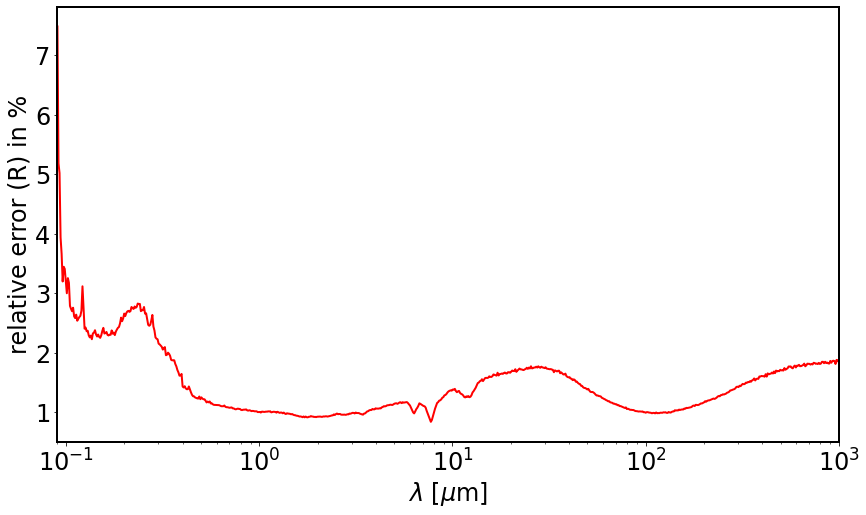

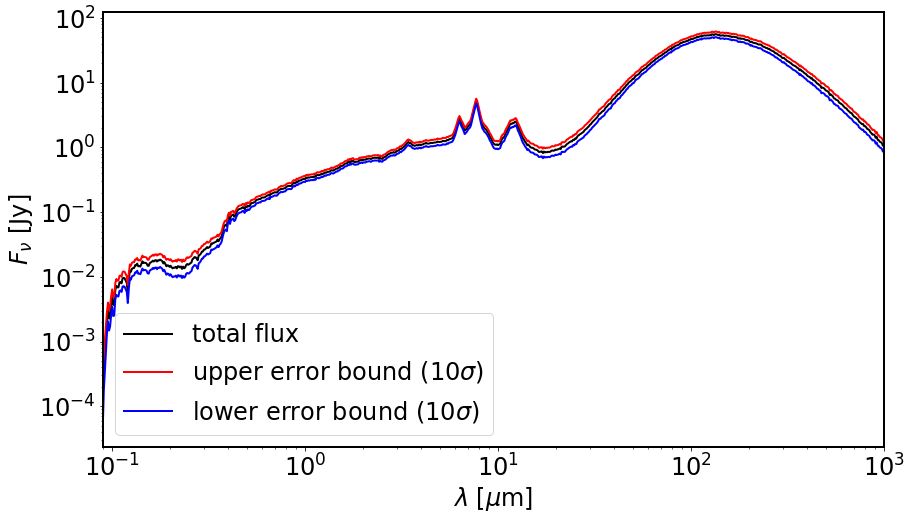

In [36]:
N = 5e6
Rs = np.sqrt(dat_stats['Sum[w_i**2] (1)']/dat_stats['Sum[w_i**1] (1)']**2 - 1/N)

plt.figure(figsize=(14, 8))
plt.xscale('log')
plt.xlabel(r'$\lambda$ [$\mu$m]')
plt.ylabel('relative error (R) in %')
plt.plot(dat_stats['wavelength; lambda (micron)'], 100*Rs, lw=2, color='red')
plt.xlim([0.09, 1000])

plt.figure(figsize=(14, 8))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda$ [$\mu$m]')
plt.ylabel(r'$F_\nu$ [Jy]')
plt.plot(dat_stats['wavelength; lambda (micron)'], dat['total flux; F_nu (Jy)'], label='total flux', lw=2, color='black')
plt.plot(dat_stats['wavelength; lambda (micron)'], dat['total flux; F_nu (Jy)']*(1+10*Rs), label=r'upper error bound (10$\sigma$)', lw=2, color='red')
plt.plot(dat_stats['wavelength; lambda (micron)'], dat['total flux; F_nu (Jy)']*(1-10*Rs), label=r'lower error bound (10$\sigma$)', lw=2, color='blue')
plt.xlim([0.09, 1000])
plt.legend()